# Python/Kerasで深層学習：
# MNISTからVAEで類似画像生成

https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3  
session = tf.Session(config=config)
import keras
from keras import backend as K
K.set_session(session) 

Using TensorFlow backend.


In [2]:
#from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

original_dim = 784
latent_dim = 2
intermediate_dim = 256
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


In [4]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: UserWarning: Output "dense_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_5" during training.


In [5]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape[0], '訓練データ数')
print(x_test.shape[0], 'テストデータ数')


60000 訓練データ数
10000 テストデータ数


In [6]:
batch_size = 100
epochs = 50

history_vae = vae.fit(x_train, 
                      shuffle=True, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      validation_data=(x_test, None))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 66us/step - loss: 190.5970 - val_loss: 171.1988
Epoch 2/50
60000/60000 [==============================] - 3s 51us/step - loss: 169.3224 - val_loss: 167.7115
Epoch 3/50
60000/60000 [==============================] - 3s 58us/step - loss: 166.6059 - val_loss: 165.8065
Epoch 4/50
60000/60000 [==============================] - 4s 63us/step - loss: 164.5587 - val_loss: 163.7591
Epoch 5/50
60000/60000 [==============================] - 4s 62us/step - loss: 163.0753 - val_loss: 162.6719
Epoch 6/50
60000/60000 [==============================] - 4s 59us/step - loss: 161.8630 - val_loss: 162.0237
Epoch 7/50
60000/60000 [==============================] - 3s 57us/step - loss: 160.7489 - val_loss: 160.5561
Epoch 8/50
60000/60000 [==============================] - 4s 60us/step - loss: 159.7444 - val_loss: 159.7621
Epoch 9/50
60000/60000 [==============================] - 4s 59us/step - loss:

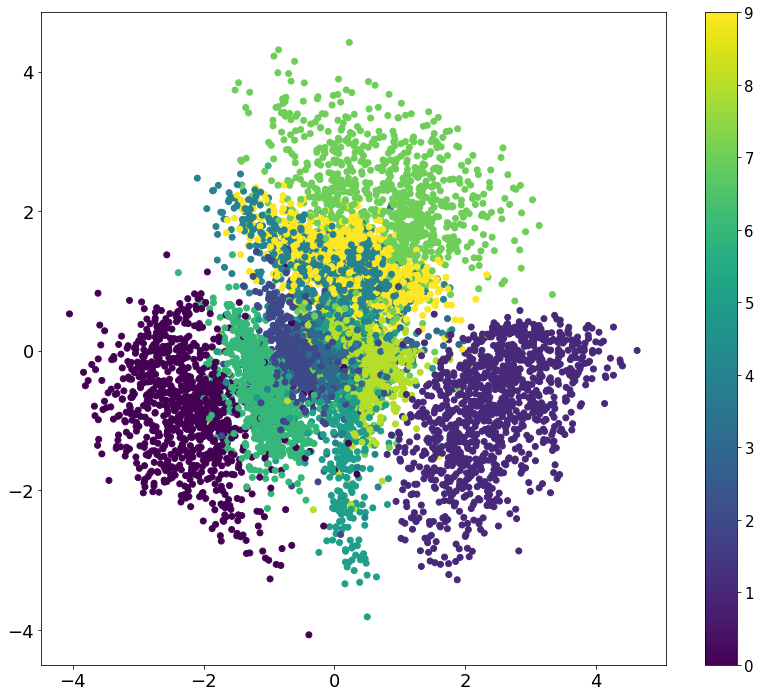

In [7]:
%matplotlib inline

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(14,12))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15) # colorbarのサイズ
#plt.ylabel('Y',fontsize=20,font_properties=fp2)
#plt.xlabel('X',fontsize=20,font_properties=fp2)
plt.tick_params(labelsize=18) # 軸上の文字のサイズ
plt.savefig('Python-MNIST-VAE-Latent.pdf')
plt.show()


In [8]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


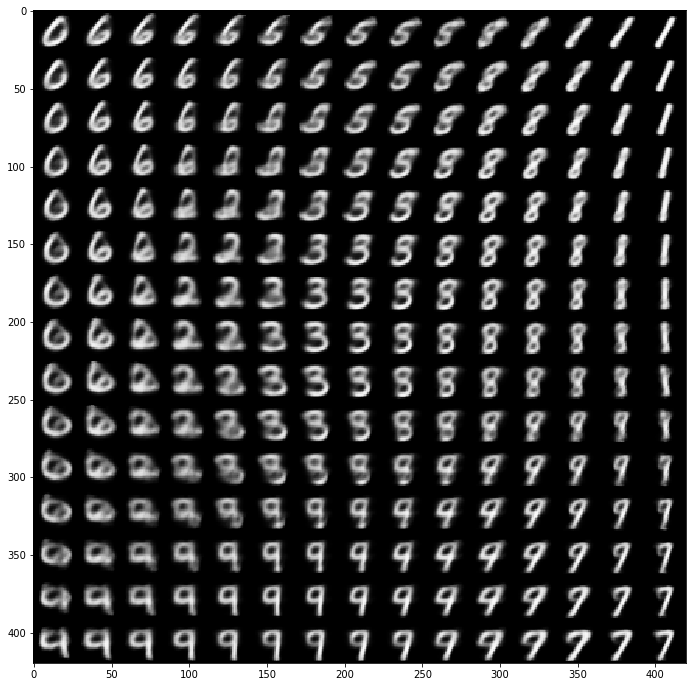

In [9]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(12, 12))
plt.imshow(figure, cmap='Greys_r')
plt.show()

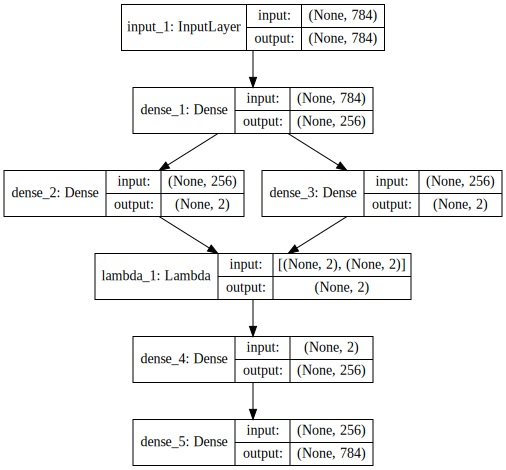

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils.vis_utils import plot_model
plot_model(vae, show_shapes=True, to_file='Python-MNIST-VAE-0encoder.jpg')

SVG(model_to_dot(vae,show_shapes=True).create(prog='dot', format='svg'))


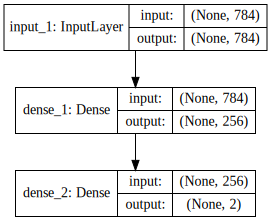

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils.vis_utils import plot_model
plot_model(encoder, show_shapes=True, to_file='Python-MNIST-VAE-Encoder.jpg')

SVG(model_to_dot(encoder,show_shapes=True).create(prog='dot', format='svg'))

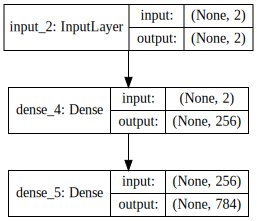

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils.vis_utils import plot_model
plot_model(generator, show_shapes=True, to_file='Python-MNIST-VAE-Generator.jpg')

SVG(model_to_dot(generator,show_shapes=True).create(prog='dot', format='svg'))


In [13]:
# HDF5ファイルでモデル全体とモデルの重みを保存
vae.save("Python-MNIST-VAE.h5")
vae.save_weights("Python-MNIST-VAE-weights.h5")

In [14]:
# pickleで訓練のヒストリーを保存
import pickle
with open('Python-MNIST-VAE.pkl', 'wb') as h_file:
    pickle.dump(history_vae.history, h_file)

In [15]:
# Matplotlibのフォントの制御（大きさや種類）
%matplotlib inline
import numpy as np # Numpy
import matplotlib
import matplotlib.pyplot as plt # 描画ライブラリ
print (matplotlib.rcParams.get('font.family'))
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

font_prop = fm.FontProperties()  
font_prop.set_style('normal')
font_prop.set_weight('light')
font_prop.set_size('12')

fp2 = font_prop.copy()# フォントプロパティ(FP)をコピー
fp2.set_size('20')# フォントプロパティ(FP)をコピー
fp2.set_family('serif')# フォントはSerif(明朝体など）に設定

['sans-serif']


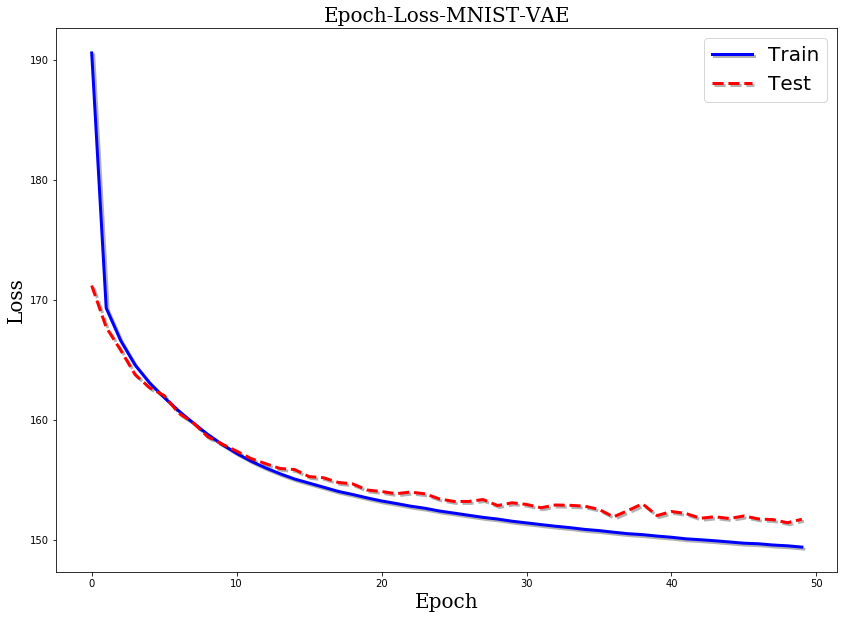

In [16]:
# 損失グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(history_vae.history['loss'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history_vae.history['val_loss'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.title('Epoch-Loss-MNIST-VAE',fontsize=25,font_properties=fp2)
plt.ylabel('Loss',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Train', 'Test'], loc='best', fontsize=20)
plt.savefig('Epoch-Loss-MNIST-VAE.pdf')
plt.show()

In [17]:
# list all data in history
print(history_vae.history.keys())


dict_keys(['loss', 'val_loss'])
